## Analysis variant selection to the graphs

This notebook is used to reproduce the analysis presented in the variant selection section. 

We constructed variation graphs using *vg toolkit* where the variants filtered based on the pregressively increasing allele frequency in each breeds, starting from af=0 (all variants) to 0.1 with 0.01 increment, and 0.1-1.0 with 0.1 increment.

In [2]:
library(tidyverse)
library(magrittr)
library(cowplot)

### Graph statistics

This part will investigate the graph complexity as increasing number of variants augmented to the graphs


`var_count.tsv` contained the allele frequency threshold and the number of variants augmented to the graphs, respectively.

`graphs_stat.tsv` contained the info on frequency threshold, breeds, length graphs, number of nodes, number of edges, 
obtained with `vg stat`

In [3]:
## parsing the graph statistics file
datcount <- read.table("../result/var_count.tsv",header=TRUE)
colnames(datcount) <- c("freq_thresh","in_graph")
datnode <- read.table("../result/graphs_stat.tsv",header=FALSE)
colnames(datnode) <- c("freq_thresh","breeds","length","nodes","edges")

## combine number of variants in the graphs with node-edges information
datnode_comb <- datnode %>% left_join(datcount,by="freq_thresh")
head(datnode_comb)

freq_thresh,breeds,length,nodes,edges,in_graph
0.04,BSW,42587620,1870866,2106101,229360
0.00,BSW,42662064,2025291,2327614,293804
0.01,BSW,42655305,2024290,2326178,293628
0.02,BSW,42612303,1927278,2186974,253014
0.03,BSW,42602051,1903766,2153244,243145
0.04,BSW,42587620,1870866,2106101,229360


### Plot relation between number variants in the graphs with graph complexity

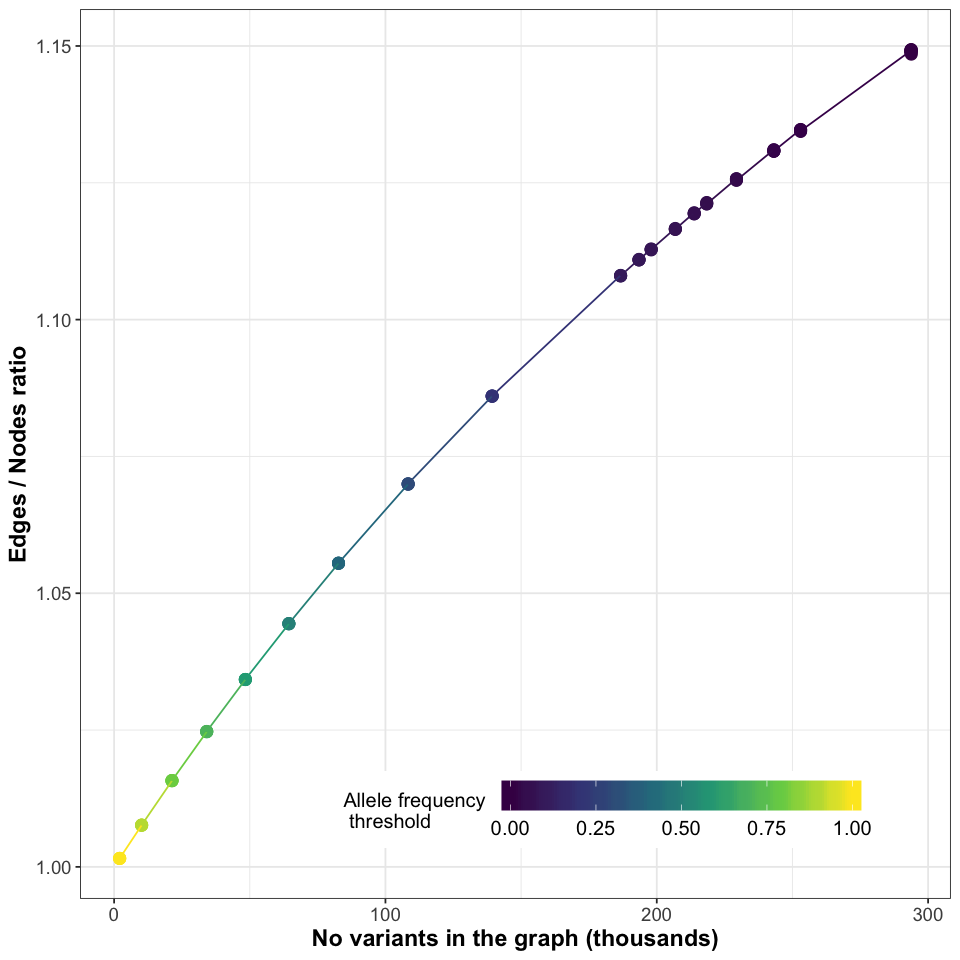

In [4]:
options(repr.plot.width=8, repr.plot.height=8)
plot1  <- ggplot(data=datnode_comb,aes(x=in_graph,y=edges/nodes,col=freq_thresh)) +
  geom_point(size=3)+
  geom_line()+
  theme_bw()+
  theme(text = element_text(size=14),
        legend.position = c(0.6,0.1),
        legend.direction ="horizontal",
        legend.text = element_text(size=12),
        legend.title = element_text(size=12),
          axis.title = element_text(face="bold"))+
  scale_colour_viridis_c(guide = guide_colourbar(barwidth=15,
                                                 barheight = 1.25))+
  scale_x_continuous(breaks = seq(0,3*10^5,10^5),
                     labels = seq(0,300,100))+
  labs(x="No variants in the graph (thousands)",
       y="Edges / Nodes ratio",
       col="Allele frequency \n threshold")

plot1

In [5]:
### get average of statistics across breeds
datnode_sum <- datnode_comb %>% group_by(freq_thresh) %>% 
  summarise(length=mean(length),
            nodes=mean(nodes),
            edges=mean(edges),
            in_graph=mean(in_graph))
datnode_sum

freq_thresh,length,nodes,edges,in_graph
0.00,42658939,2023580,2325142,293804
0.01,42655808,2024015,2325714,293628
0.02,42611803,1927044,2186407,253014
0.03,42601207,1903666,2152791,243145
0.04,42587109,1870827,2105834,229360
0.05,42575518,1844641,2068296,218412
0.06,42570746,1833736,2052689,213794
0.07,42563595,1817080,2028867,206828
0.08,42554348,1795776,1998388,197927
0.09,42549775,1785075,1983108,193444


In [6]:
### Correlation between number of variants in the graphs and edges/nodes ratio
cor(datnode_sum$in_graph,datnode_sum$edges/datnode_sum$nodes)

[1] 0.9949925

## Allele frequency effect on the graph mapping accuracy

We mapped the simulated reads from each breeds with all graphs constructed from the same breeds.   


File `graphmap_freq_stat.tsv` contained the info on breeds, allele freq threshold, mapping mode (single- or paired-end), and number of reads mapped incorrectly among 10 million mapped reads.

In [7]:
## Parse the graph mapping results. 
datgraph <- read.table("../result/graphmap_freq_stat.tsv",header=FALSE)
colnames(datgraph) <- c("breed","freq","mode","map_err")
datgraph$prop <- datgraph$map_err*100/10^7
datgraph$mapper <- 'vg'
head(datgraph)

breed,freq,mode,map_err,prop,mapper
BSW,0.00,se,34920,0.34920,vg
BSW,0.00,pe,7751,0.07751,vg
BSW,0.01,se,32025,0.32025,vg
BSW,0.01,pe,7391,0.07391,vg
BSW,0.02,se,31798,0.31798,vg
BSW,0.02,pe,7307,0.07307,vg


File `linearmap_stat.tsv` contained info on linear mapping statistics from each breeds either using vg (with empty graph) or with bwa

In [8]:
## get map err for linear mapping
datlin <- read.table("../result/linearmap_stat.tsv")
colnames(datlin) <- c("breed","freq","mode","mapper","map_err","total_reads")
datlin$prop <- datlin$map_err*10^2/datlin$total_reads
datbwa <- datlin %>% filter(mapper=="bwa")
datvglin <- datlin %>% filter(mapper=="vg")
datall <- rbind(datgraph,datlin %>% select(-total_reads)) 
head(datall)
head(datbwa)

breed,freq,mode,map_err,prop,mapper
BSW,0.00,se,34920,0.34920,vg
BSW,0.00,pe,7751,0.07751,vg
BSW,0.01,se,32025,0.32025,vg
BSW,0.01,pe,7391,0.07391,vg
BSW,0.02,se,31798,0.31798,vg
BSW,0.02,pe,7307,0.07307,vg


breed,freq,mode,mapper,map_err,total_reads,prop
OBV,1.1,se,bwa,51892,10000950,0.5188707
BSW,1.1,se,bwa,52391,10000964,0.5238595
HOL,1.1,se,bwa,50483,10000894,0.5047849
FV,1.1,se,bwa,49458,10000893,0.4945358
BSW,1.1,pe,bwa,10785,10000949,0.1078398
OBV,1.1,pe,bwa,10995,10000929,0.1099398


### Plot relation between allele frequency filtering and mapping accuracy - Paired end

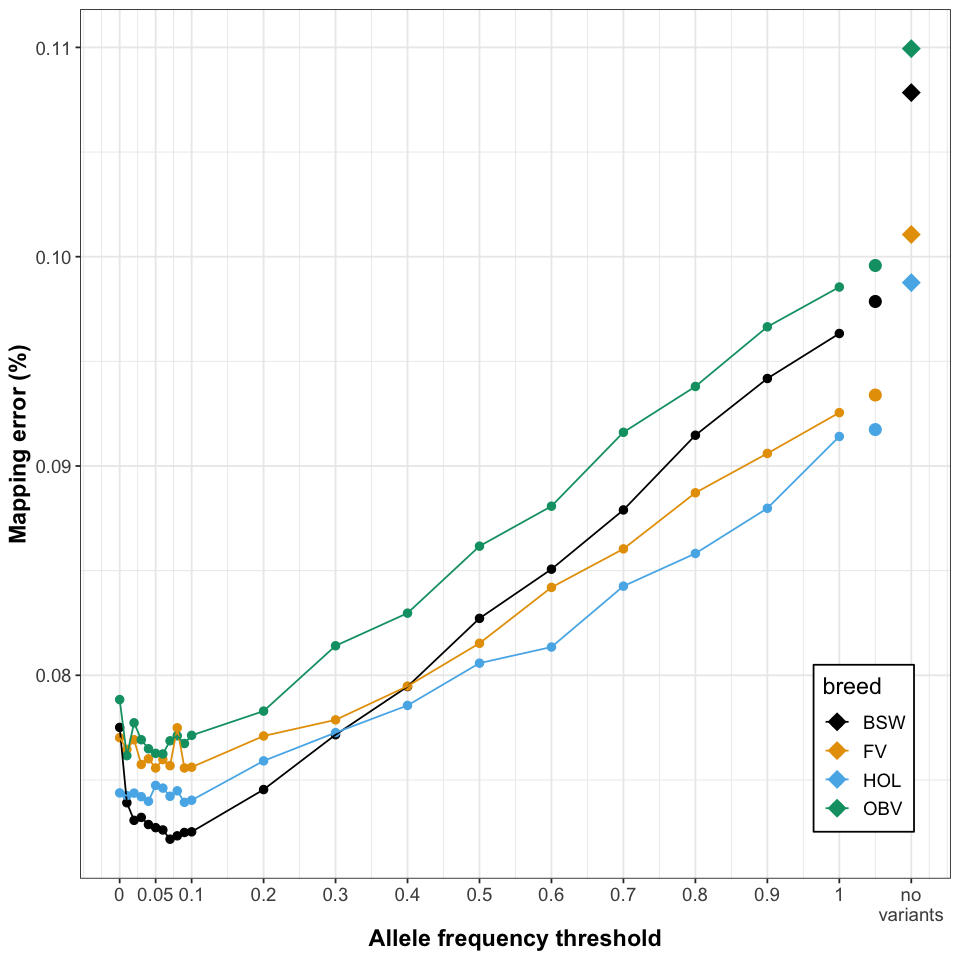

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
plot2 <- ggplot(datgraph %>% filter(mode=="pe"),aes(x=freq,y=prop,group=breed,col=breed)) +
  geom_point(size=2)+
  geom_point(data = datbwa %>% filter(mode=="pe"),shape=18,aes(x=1.1,y=prop),size=5)+
  geom_point(data = datvglin %>% filter(mode=="pe"),aes(x=1.05,y=prop),size=3)+
  geom_line(size=0.5)+
  theme_bw()+
  scale_x_continuous(breaks = c(0,0.05,seq(0.1,1.1,0.1)),
                     labels = c("0","0.05",seq(0.1,1,0.1),"no\nvariants"))+
  scale_color_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_fill_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  theme(text = element_text(size=14),
        legend.position = c(0.9,0.15),
        axis.title = element_text(face="bold"),
        legend.background = element_rect(colour = "black")) +
  labs(x="Allele frequency threshold",
       y="Mapping error (%)")
plot2

### Zoom in plot for AF less than 0.1

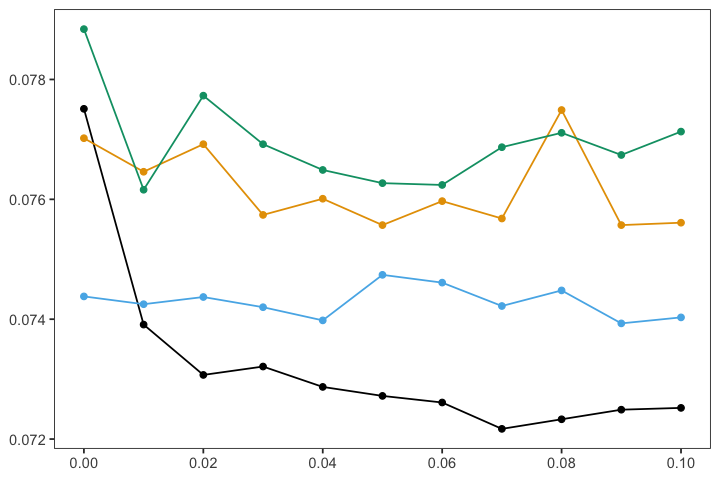

In [10]:
options(repr.plot.width=6, repr.plot.height=4)
plow_pe <- ggplot(datgraph %>% filter(mode=="pe" & freq<=0.1),aes(x=freq,y=prop,group=breed,col=breed))+
  geom_point()+
  geom_line()+
  scale_color_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_fill_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_x_continuous(breaks = seq(0,0.1,0.02))+
  theme_bw()+
  theme(legend.position = "None",
        axis.title = element_blank(),
        panel.grid = element_blank(),
        legend.background = element_rect(colour="black"))
plow_pe

### Statistical analysis of variants selection in paired-end result

In [11]:
datgraph_pe<- datgraph %>% filter(mode=="pe")
datgraph_pe$prop  <- datgraph_pe$map_err*10^2/10^7

#### Correlation between mapping error and allele frequency threshold

In [12]:
cor.test(datgraph_pe$freq,datgraph_pe$map_err,method="pearson")


	Pearson's product-moment correlation

data:  datgraph_pe$freq and datgraph_pe$map_err
t = 24.165, df = 78, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9066154 0.9606985
sample estimates:
      cor 
0.9392374 


#### Correlation in high allele frequency >= 0.1

In [13]:
datgraph_pe_high <- datgraph_pe %>% filter(freq>=0.1)
cor.test(datgraph_pe_high$freq,datgraph_pe_high$map_err)


	Pearson's product-moment correlation

data:  datgraph_pe_high$freq and datgraph_pe_high$map_err
t = 16.498, df = 38, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8828616 0.9662883
sample estimates:
      cor 
0.9367471 


#### Correlation in low allele frequency < 0.1

In [14]:
datgraph_pe_low <- datgraph_pe %>% filter(freq<0.1)
cor.test(datgraph_pe_low$freq,datgraph_pe_low$map_err)


	Pearson's product-moment correlation

data:  datgraph_pe_low$freq and datgraph_pe_low$map_err
t = -1.5179, df = 38, p-value = 0.1373
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.51243235  0.07824919
sample estimates:
      cor 
-0.239088 


#### Testing on breed's difference

In [15]:
anova(lm(map_err ~ freq*breed,data=datgraph_pe))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
freq,1,32102459.3,32102459.30,1815.95272,8.095927e-53
breed,3,2015964.1,671988.03,38.01262,7.776694e-15
freq:breed,3,999219.9,333073.31,18.84109,4.023757e-09
Residuals,72,1272817.9,17678.03,NA,NA


#### Correlation between single- and paired-end data

In [16]:
datgraph_se  <-  datgraph %>% filter(mode=="se")
cor.test(datgraph_se$freq,datgraph_pe$map_err,method="pearson")


	Pearson's product-moment correlation

data:  datgraph_se$freq and datgraph_pe$map_err
t = 24.165, df = 78, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9066154 0.9606985
sample estimates:
      cor 
0.9392374 


### Plot relation between allele frequency filtering and mapping accuracy - Single end

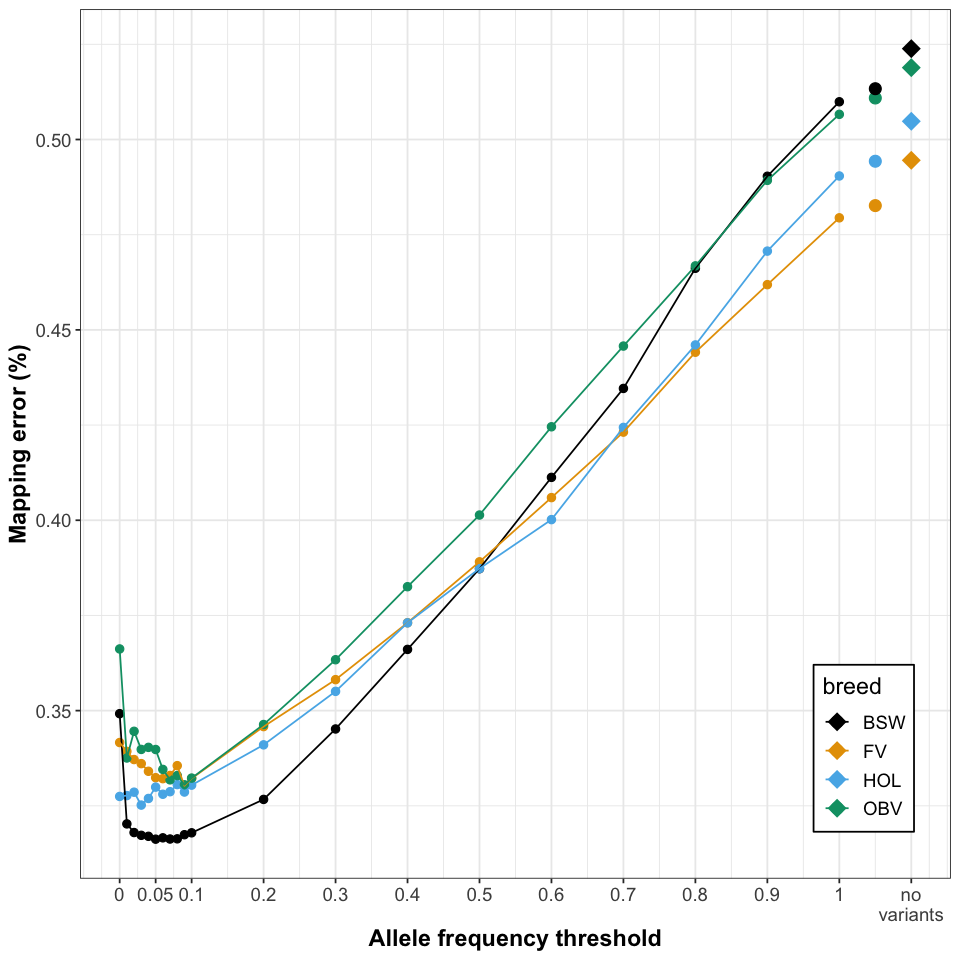

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
plot2_se <- ggplot(datgraph %>% filter(mode=="se"),aes(x=freq,y=prop,group=breed,col=breed)) +
  geom_point(size=2)+
  geom_point(data = datbwa %>% filter(mode=="se"),shape=18,aes(x=1.1,y=prop),size=5)+
  geom_point(data = datvglin %>% filter(mode=="se"),aes(x=1.05,y=prop),size=3)+
  geom_line(size=0.5)+
  theme_bw()+
  scale_x_continuous(breaks = c(0,0.05,seq(0.1,1.1,0.1)),
                     labels = c("0","0.05",seq(0.1,1,0.1),"no\nvariants"))+
  scale_color_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_fill_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  theme(text = element_text(size=14),
        legend.position = c(0.9,0.15),
        axis.title = element_text(face="bold"),
        legend.background = element_rect(colour = "black")) +
  labs(x="Allele frequency threshold",
       y="Mapping error (%)")
plot2_se

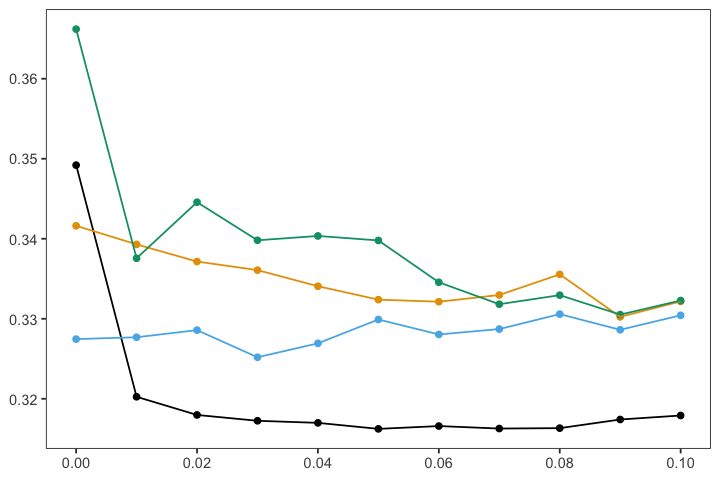

In [18]:
options(repr.plot.width=6, repr.plot.height=4)
plow_se <- ggplot(datgraph %>% filter(mode=="se" & freq<=0.1),aes(x=freq,y=prop,group=breed,col=breed))+
  geom_point()+
  geom_line()+
  scale_color_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_fill_manual(values=c("#000000", "#E69F00", "#56B4E9", "#009E73"))+
  scale_x_continuous(breaks = seq(0,0.1,0.02))+
  theme_bw()+
  theme(legend.position = "None",
        axis.title = element_blank(),
        panel.grid = element_blank(),
        legend.background = element_rect(colour="black"))
plow_se

### Comparison of filtering variants and randomly sampled variants 

In this setting, I build graphs with the same number of variants (but randomly sampled) as when variants filtered by allele frequency.

File `randommap_stat.tsv` contained the same info as in the `graphmap_freq_stat.tsv`, but on randomly sampled variants

In [19]:
datrand <- read.table("../result/randommap_stat.tsv")
colnames(datrand)  <- c("breeds","freq","mode","map_err","samp")
head(datrand)

breeds,freq,mode,map_err,samp
BSW,0.00,pe,7804,random_sampling
BSW,0.00,se,34898,random_sampling
BSW,0.01,pe,7735,random_sampling
BSW,0.01,se,34905,random_sampling
BSW,0.02,pe,7705,random_sampling
BSW,0.02,se,36349,random_sampling


Combined with graph mapping accuracy with filtering variants.

In [20]:
dataf <- read.table("../result/graphmap_freq_stat.tsv",header=FALSE)
dataf$samp  <- "with_af"
colnames(dataf) <- c("breeds","freq","mode","map_err","samp")
datcon <- rbind(datrand,dataf)
head(datrand)
head(dataf)

breeds,freq,mode,map_err,samp
BSW,0.00,pe,7804,random_sampling
BSW,0.00,se,34898,random_sampling
BSW,0.01,pe,7735,random_sampling
BSW,0.01,se,34905,random_sampling
BSW,0.02,pe,7705,random_sampling
BSW,0.02,se,36349,random_sampling


breeds,freq,mode,map_err,samp
BSW,0.00,se,34920,with_af
BSW,0.00,pe,7751,with_af
BSW,0.01,se,32025,with_af
BSW,0.01,pe,7391,with_af
BSW,0.02,se,31798,with_af
BSW,0.02,pe,7307,with_af


### Plotted as the function of the number of variants

In [21]:
datmin <- read.table("../result/var_count.tsv",header=TRUE )

datall <- datcon %>% left_join(datmin, by=c("freq"="thresh")) 
datall$incor_prop <- datall$map_err*10^2/10^7
head(datmin)
head(datall)

thresh,tot_var
0.00,293804
0.01,293628
0.02,253014
0.03,243145
0.04,229360
0.05,218412


breeds,freq,mode,map_err,samp,tot_var,incor_prop
BSW,0.00,pe,7804,random_sampling,293804,0.07804
BSW,0.00,se,34898,random_sampling,293804,0.34898
BSW,0.01,pe,7735,random_sampling,293628,0.07735
BSW,0.01,se,34905,random_sampling,293628,0.34905
BSW,0.02,pe,7705,random_sampling,253014,0.07705
BSW,0.02,se,36349,random_sampling,253014,0.36349


### Plot comparison between augmented variants with filtering and random sampling - Paired end

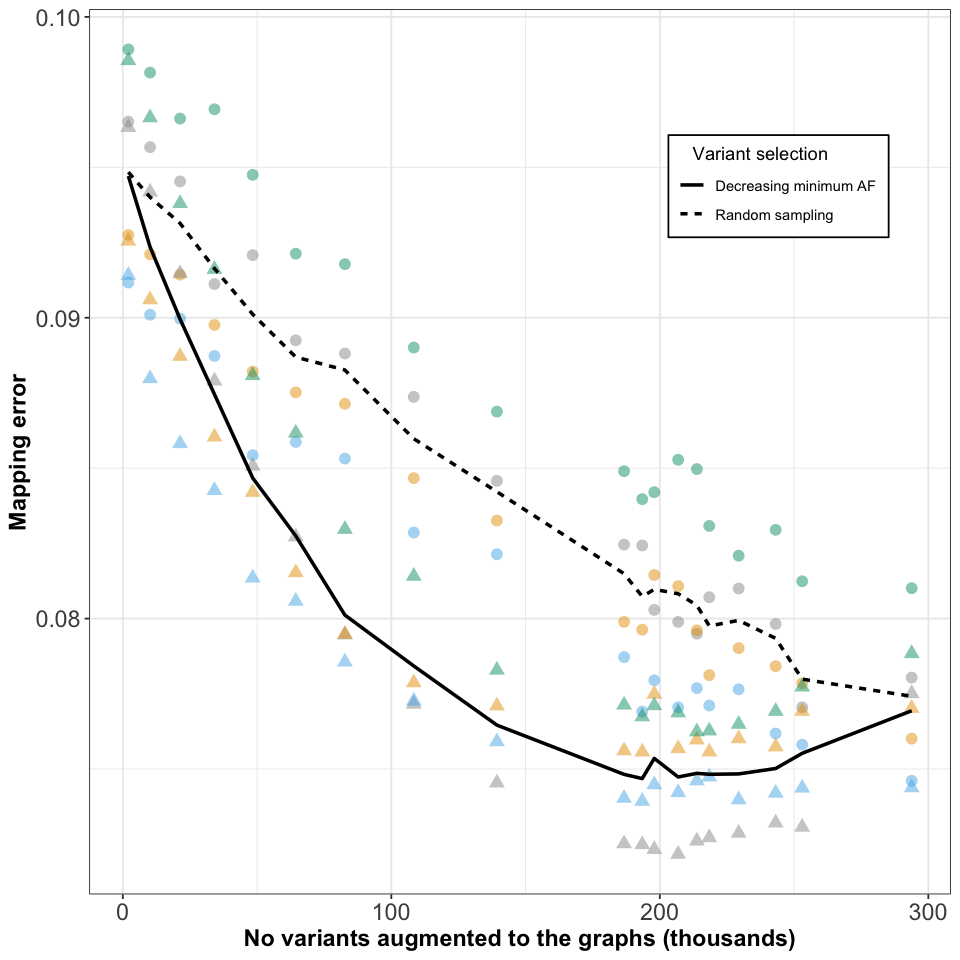

In [24]:
options(repr.plot.width=8, repr.plot.height=8)
options(warn=-1) ## remove 0.01 because is very close with the other
datall <- datall %>% filter(freq != 0.01)

###plot for paired end

datall_pe <- datall %>% filter(mode == "pe")

datsum_pe <- datall_pe %>% group_by(freq,samp) %>% 
            summarise(mean_var=mean(tot_var),
                      mean_incor=mean(incor_prop))

##correct legend
datsum_pe$samp <- ifelse(datsum_pe$samp=="with_af", "Decreasing minimum AF","Random sampling")

plot3  <- ggplot()+
  geom_point(data=datall_pe,aes(x=tot_var,y=incor_prop,col=breeds,shape=samp),size=3,alpha=0.5,show.legend = FALSE)+
  geom_line(data=datsum_pe,aes(x=mean_var,y=mean_incor,linetype=samp,group=samp),size=1)+
  theme_bw()+
  labs(x="No variants augmented to the graphs (thousands)",y="Mapping error",linetype="   Variant selection")+
  scale_x_continuous(labels=c(0,100,200,300),breaks=seq(0,3*10^5,10^5))+
  theme(axis.text = element_text(size=14),
        axis.title = element_text(size=14,face="bold"),
        legend.position = c(0.8,0.8),
        legend.background = element_rect(colour = "black"))+
  scale_colour_manual(values=c("#999999", "#E69F00", "#56B4E9", "#009E73"))

plot3

### Plot comparison between augmented variants with filtering and random sampling - Single end

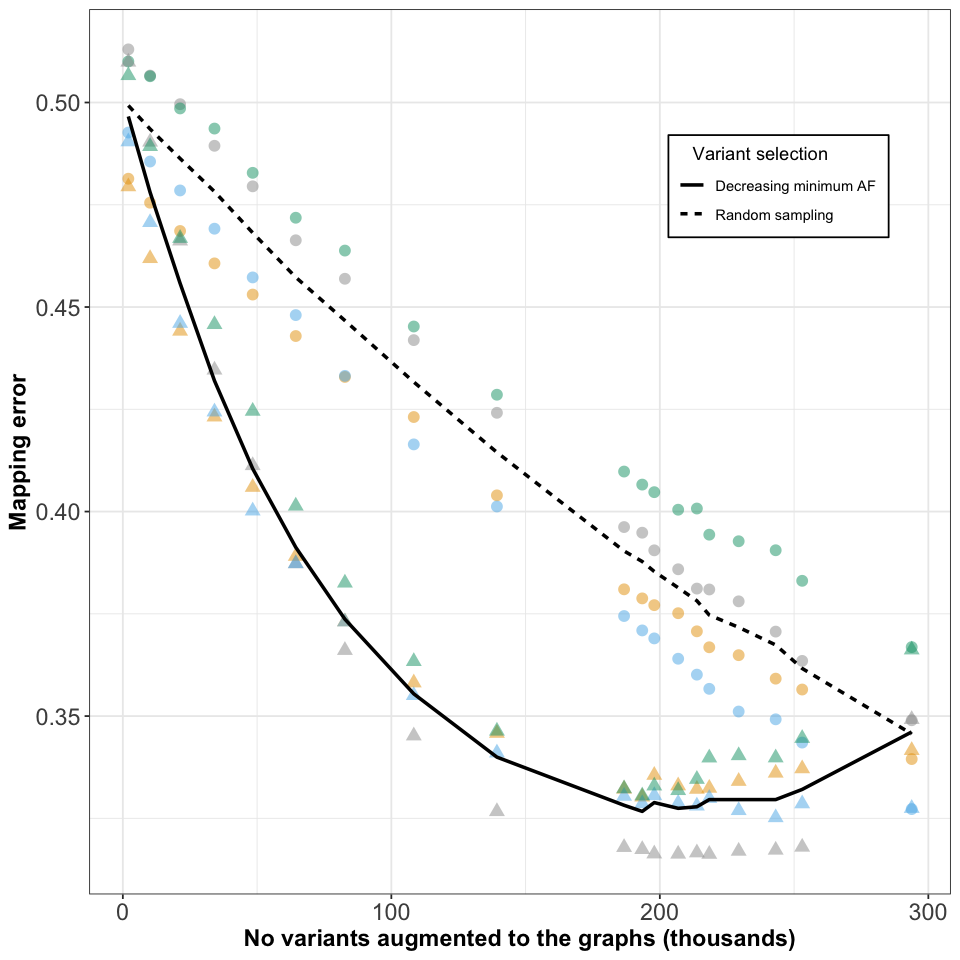

In [25]:
options(repr.plot.width=8, repr.plot.height=8)
options(warn=-1)
## remove 0.01 because is very close with the other
datall <- datall %>% filter(freq != 0.01)

###plot for paired end

datall_pe <- datall %>% filter(mode == "se")

datsum_pe <- datall_pe %>% group_by(freq,samp) %>% 
            summarise(mean_var=mean(tot_var),
                      mean_incor=mean(incor_prop))

##correct legend
datsum_pe$samp <- ifelse(datsum_pe$samp=="with_af", "Decreasing minimum AF","Random sampling")

plot3_se  <- ggplot()+
  geom_point(data=datall_pe,aes(x=tot_var,y=incor_prop,col=breeds,shape=samp),size=3,alpha=0.5,show.legend = FALSE)+
  geom_line(data=datsum_pe,aes(x=mean_var,y=mean_incor,linetype=samp,group=samp),size=1)+
  theme_bw()+
  labs(x="No variants augmented to the graphs (thousands)",y="Mapping error",linetype="   Variant selection")+
  scale_x_continuous(labels=c(0,100,200,300),breaks=seq(0,3*10^5,10^5))+
  theme(axis.text = element_text(size=14),
        axis.title = element_text(size=14,face="bold"),
        legend.position = c(0.8,0.8),
        legend.background = element_rect(colour = "black"))+
  scale_colour_manual(values=c("#999999", "#E69F00", "#56B4E9", "#009E73"))

plot3_se

In [26]:
sessionInfo()

R version 3.4.2 (2017-09-28)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_0.9.3   magrittr_1.5    forcats_0.3.0   stringr_1.3.1  
 [5] dplyr_0.8.3     purrr_0.2.5     readr_1.1.1     tidyr_1.0.0    
 [9] tibble_2.1.1    ggplot2_3.2.0   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-1         tidyselect_0.2.5     repr_0.12.0         
 [4] haven_1.1.2          lattice_0.20-35      colorspace_1.3-2    
 [7] vctrs_0.2.0          generics_0.0.2       viridisLite_0.3.0   
[10] rlang_0.4.0          pillar_1.4.2         glue_1.3.1          
[13] withr_2.1.2          modelr_0.1.2       